# Analyse CMIP5 and CMIP6 ODSL data and plot

In [107]:
import sys

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../Project_ProbSLR/CMIP_SeaLevel/code/')
import mod_loc as loc
import mod_postpro as pp

import regionmask
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from scipy.stats import linregress

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Read and prepare CMIP data

In [12]:
def read_zos_ds(data_dir, mip, sce):
    '''Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets'''
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_historical/{mip}_zos_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_{sce}/{mip}_zos_{sce}_*.nc')

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
    
    return tot_ds

In [13]:
# Check two path:
# ../Project_ProbSLR/CMIP_SeaLevel/outputs

# ../Project_ProbSLR/Data_Proj/Data_cmip5
# ../Project_ProbSLR/Data_Proj/Data_cmip6

In [16]:
cmip5_data_dir = '../Project_ProbSLR/CMIP_SeaLevel/outputs'
cmip6_data_dir = '../Project_ProbSLR/CMIP_SeaLevel/outputs'


In [17]:
cmip5_26_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp26')
cmip6_126_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp126')

cmip5_26_zos

<xarray.Dataset>
Dimensions:                 (model: 20, lat: 180, lon: 360, time: 201)
Coordinates:
  * model                   (model) object 'CCSM4' 'CNRM-CM5' ... 'bcc-csm1-1-m'
  * lat                     (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                     (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * time                    (time) float64 1.9e+03 1.902e+03 ... 2.1e+03 2.1e+03
Data variables:
    CorrectedReggrided_zos  (model, time, lat, lon) float64 dask.array<chunksize=(1, 106, 180, 360), meta=np.ndarray>
Attributes:
    source_file:        This NetCDF file was built from ComputeOceanDynmicSea...
    creation_date:      2021-07-17 02:38
    emission_scenario:  historical

### Select region of interest

In [23]:
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

ECE3_126_zos = cmip6_126_zos.CorrectedReggrided_zos.sel(model='EC-Earth3').isel(time=0)

# Define the mask and change its value from 0 to 1
mask_cmip = NLregion.mask_3D(ECE3_126_zos.lon, ECE3_126_zos.lat)



Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

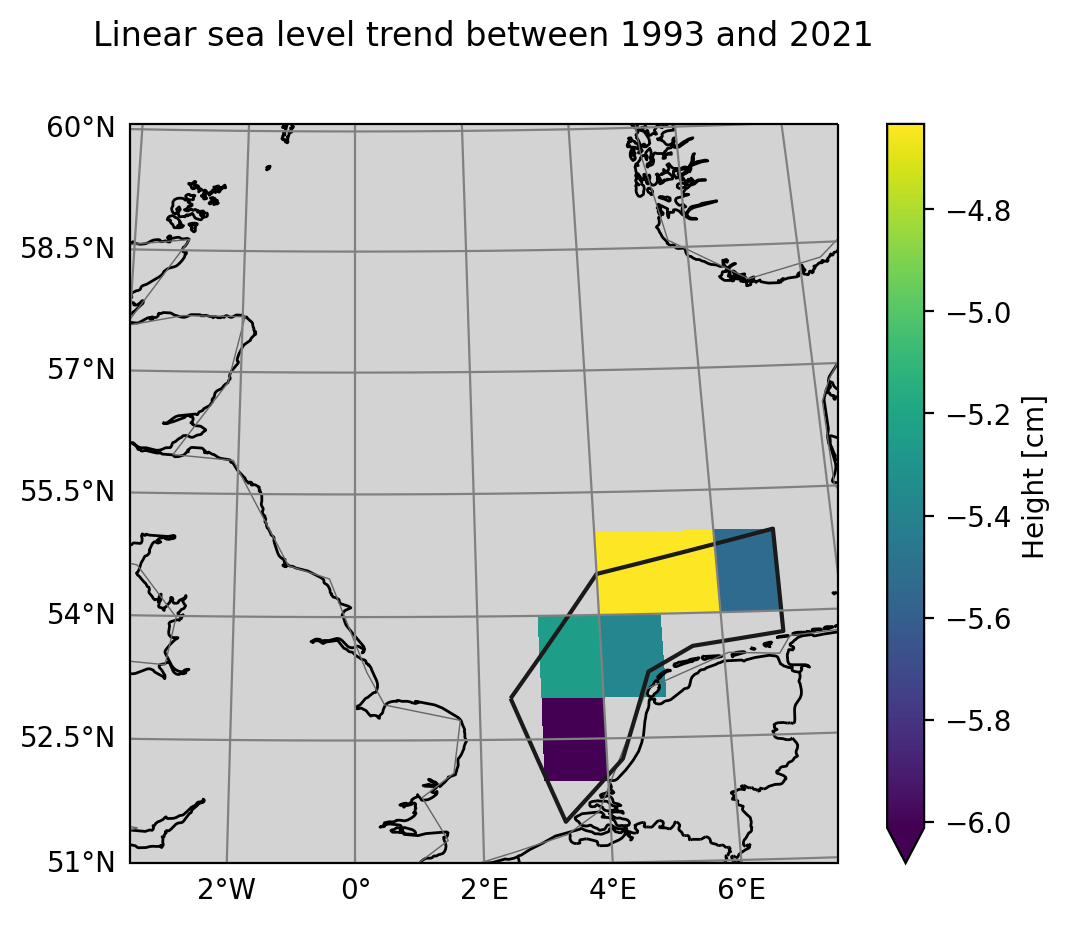

In [24]:
ECE3_126_zos_m = ECE3_126_zos.where(mask_cmip)

p = ECE3_126_zos_m.sel(lon=slice(lon_min-1,lon_max+1), 
                       lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'Height [cm]'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

In [54]:
def ds2df(cmip_ds, polygone_coord, start_year, end_year):
    '''Transform a dataset to a dataframe by averaging sea level over a region'''
    
    region = regionmask.Regions([polygone_coord], names=['Reg'], abbrevs=['Reg'])
    
    # Define the mask and change its value from 0 to 1
    mask_cmip = region.mask_3D(cmip_ds.lon, cmip_ds.lat)
    
    #cmip_ds_m = cmip_ds.CorrectedReggrided_zos.where(mask_cmip)
    
    weights = np.cos(np.deg2rad(cmip_ds.lat))

    sel_da = cmip_ds.weighted(mask_cmip * weights).mean(dim=('lat', 'lon'))

    df = pd.DataFrame(dict(time=np.arange(start_year,end_year)+0.5))
    df = df.set_index('time')

    for mod in sel_da.model.values:
        df[mod] = sel_da.sel(model=mod).isel(region=0).drop_vars(
            ['model', 'region', 'abbrevs', 'names']).to_dataframe()
        
    return df

In [62]:
start_year = 1900 #1970 #2006
end_year = 2100

#lon_min, lon_max, lat_min, lat_max = pp.define_area('knmi14_reg')
#cmip5_df = pp.ds2df(cmip5_zos, lon_min, lon_max, lat_min, lat_max, start_year, end_year)
#cmip6_df = pp.ds2df(cmip6_zos, lon_min, lon_max, lat_min, lat_max, start_year, end_year)

cmip6_126_df = ds2df(cmip6_126_zos, NL, start_year, end_year)

## Compute linear sea level trends

In [188]:
def compute_linregress_trend_error(df):
    ''' Compute the trend and error in the trend given an dataframe of ODSL time 
    series for each models'''
    
    df = df*10 # Convert height from cm to mm
    
    length = np.arange(15,51,5)
    end_year = np.arange(1960,2031,5)
    
    slope = np.zeros([len(df.columns), len(length), len(end_year)])
    stderr = np.zeros([len(df.columns), len(length), len(end_year)])
    
    for idx_l, l in enumerate(length):
        for idx_ey, ey in enumerate(end_year):
            for m in range(len(cmip6_126_df.columns)):
                sel_df = df.loc[ey-l:ey,:].iloc[:,m]
                res = linregress(sel_df.index, sel_df)

                slope[m,idx_l,idx_ey] = res.slope
                stderr[m,idx_l,idx_ey] = res.stderr
    
    ds = xr.Dataset({'slope': (['model', 'length', 'end_year'], slope), 
                     'stderr': (['model', 'length', 'end_year'], stderr)},
                   coords={'model': ('model', df.columns),
                          'length': ('length', length),
                          'end_year': ('end_year', end_year)} )
        
    return ds
    

In [189]:
ds = compute_linregress_trend_error(cmip6_126_df)

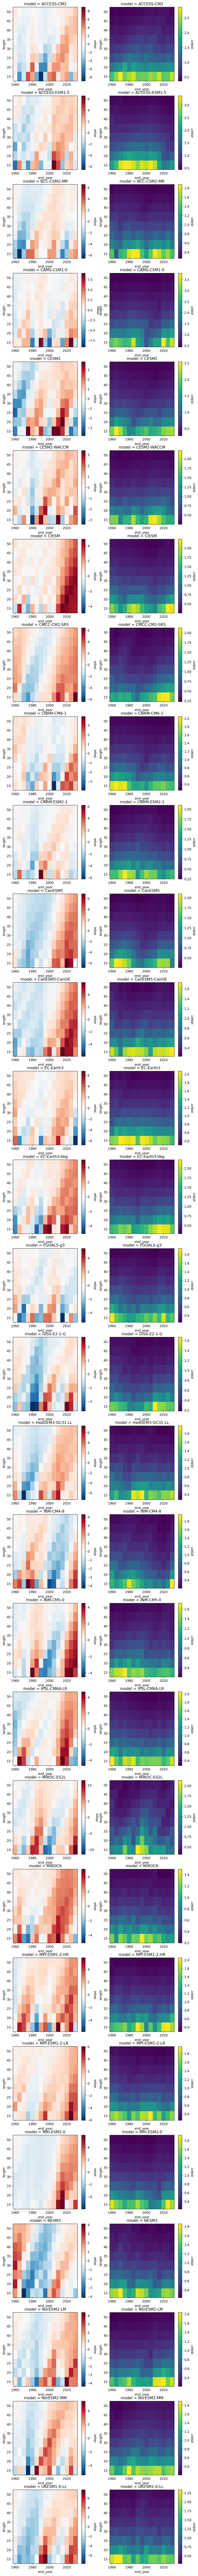

In [195]:
fig, axes = plt.subplots(nrows=len(ds.model), ncols=2, figsize=(10, len(ds.model)*5))

for idx, model in enumerate(ds.model):
    ds.slope.sel(model=model).plot(ax=axes[idx,0])
    ds.stderr.sel(model=model).plot(ax=axes[idx,1])

In [147]:
cmip6_126_df.columns

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2',
       'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3',
       'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM',
       'UKESM1-0-LL'],
      dtype='object')

In [129]:
cmip6_126_df.index.name

'time'

## Compare correlation between current trend and future 

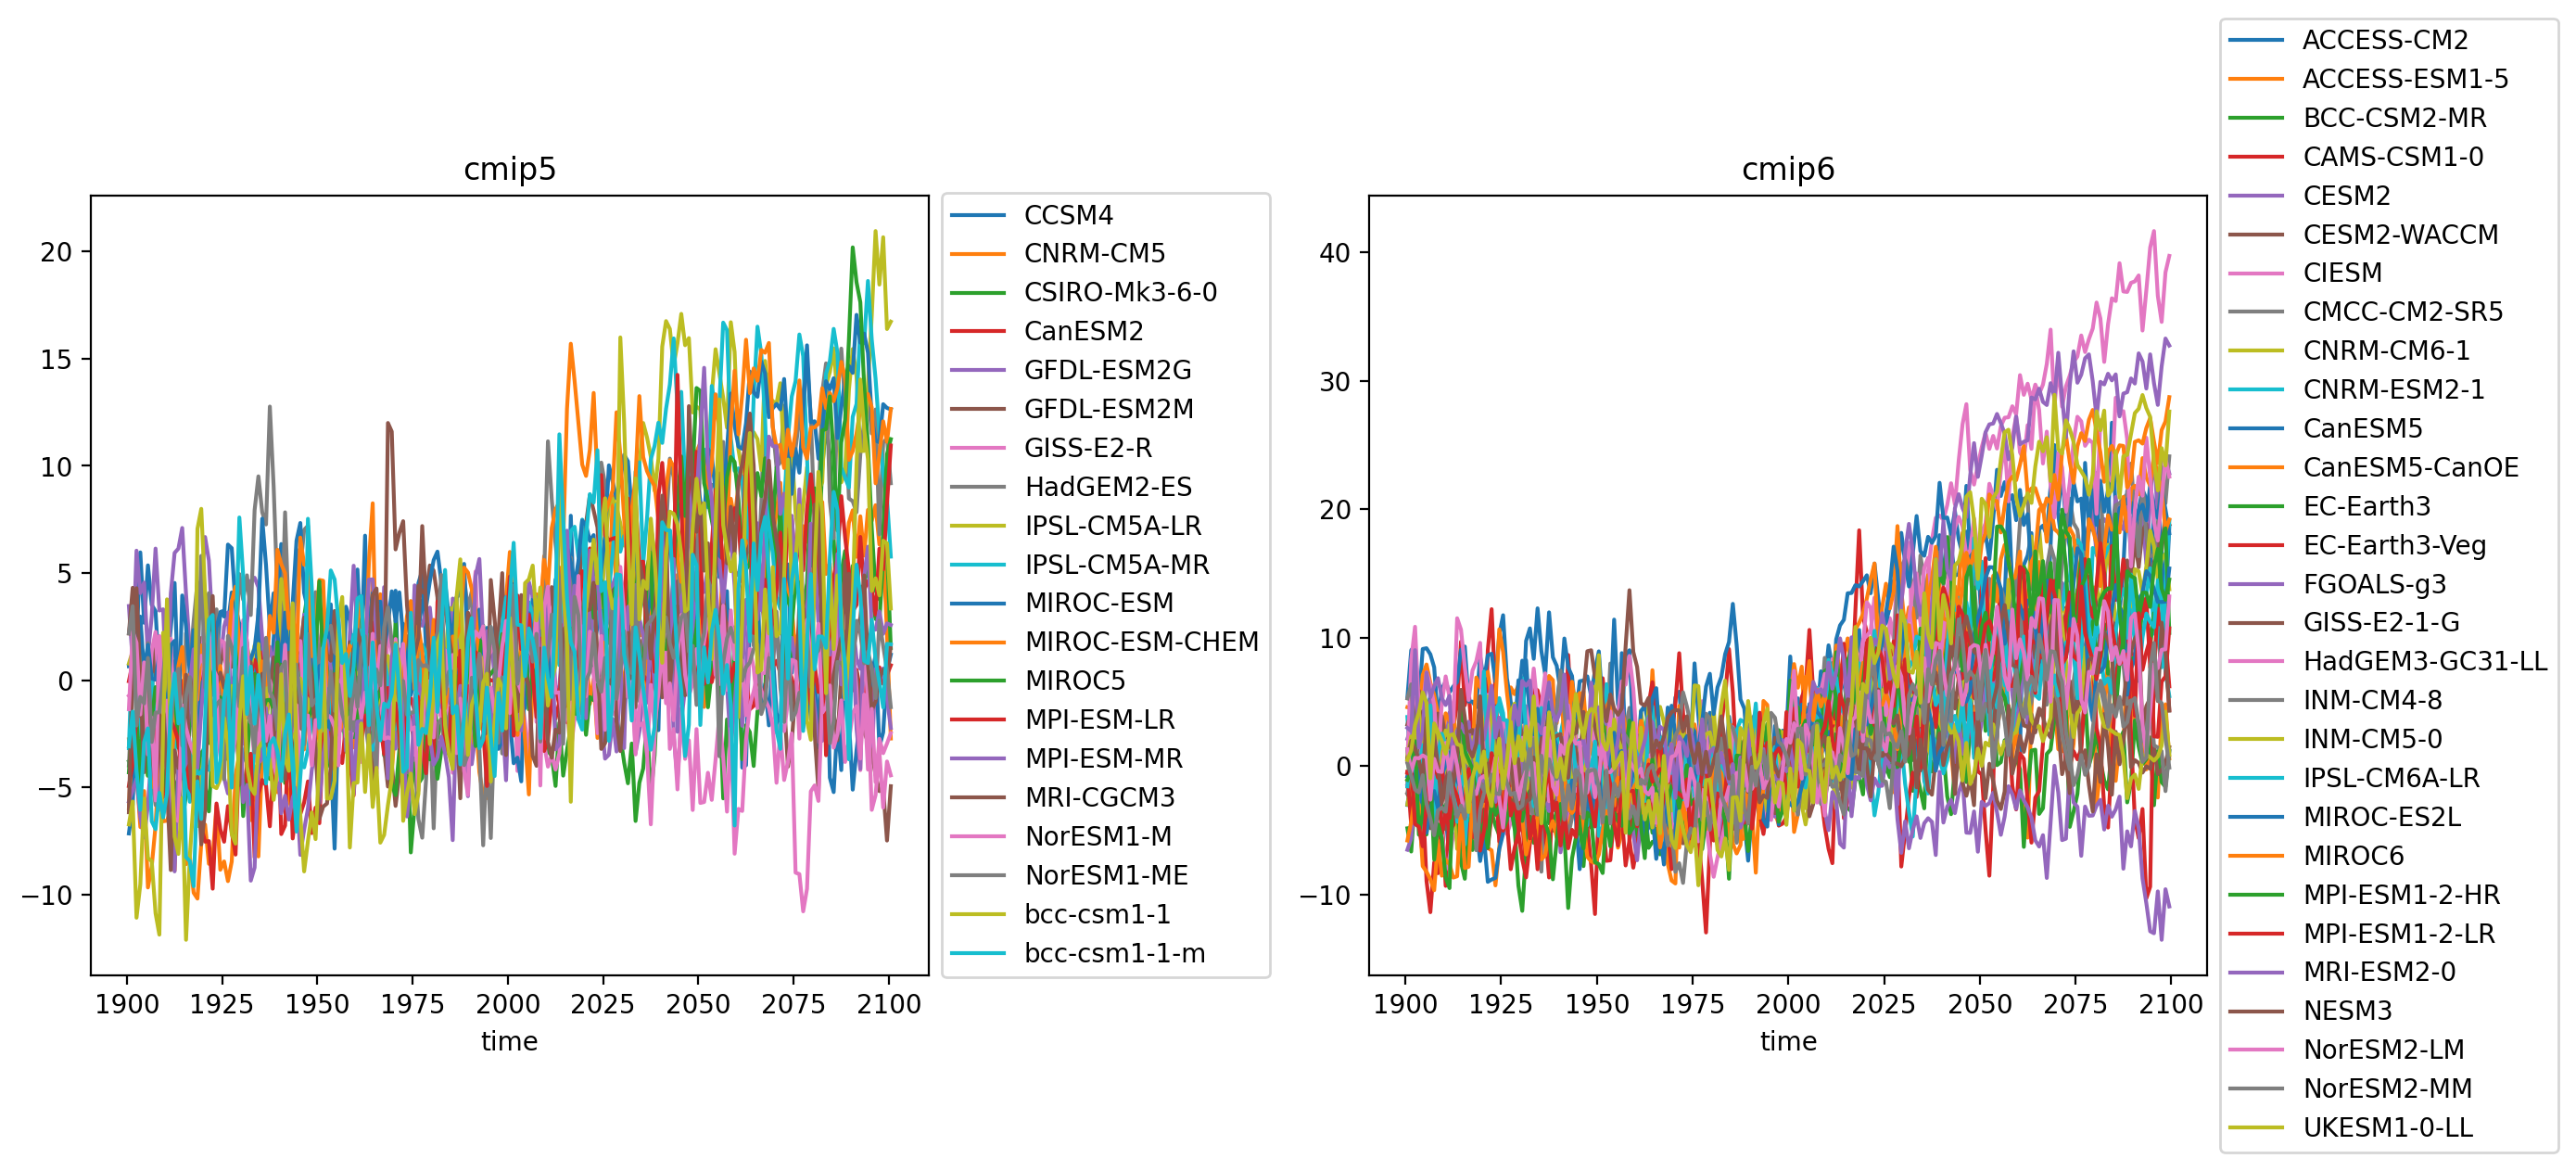

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

cmip6_126_df.plot(ax=axes[0], title='cmip5').legend(loc='center left', 
                                                bbox_to_anchor=(1, 0.5))
cmip6_df.plot(ax=axes[1], title='cmip6').legend(loc='center left', 
                                                bbox_to_anchor=(1, 0.5))

fig.tight_layout()

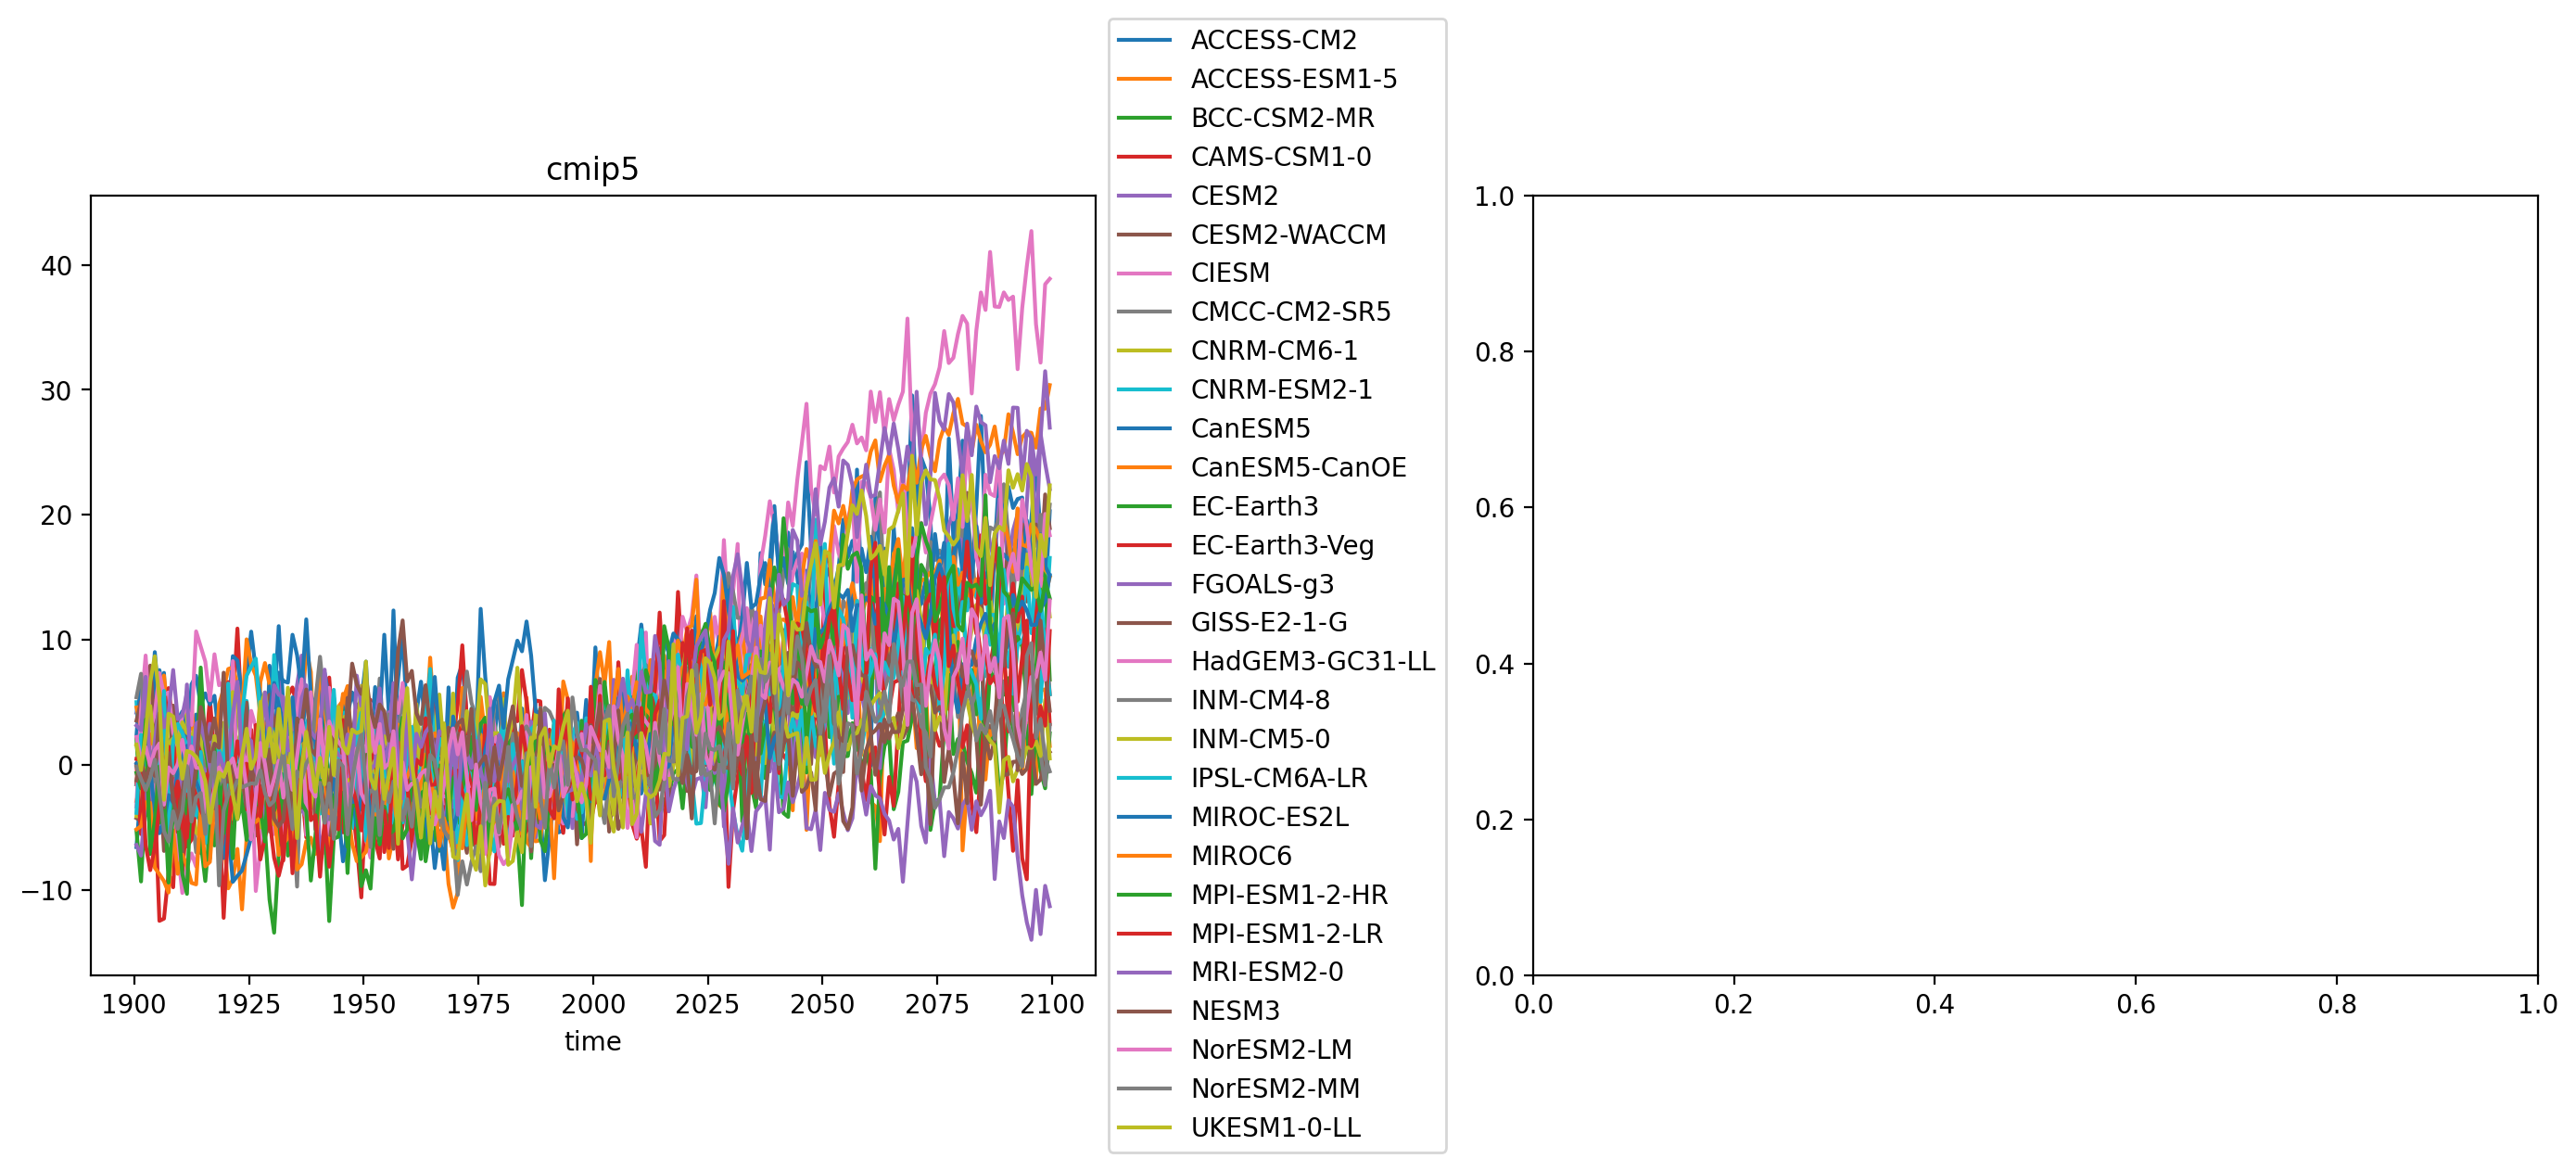

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

cmip6_126_df.plot(ax=axes[0], title='cmip5').legend(loc='center left', 
                                                bbox_to_anchor=(1, 0.5))


fig.tight_layout()